# Classifaing both Alzheimer's and Brain Tumor

I will build step by step model to evaluate the MRI Images and find Alzheimer's disease severity, type of Brain tumor on no disease

In [109]:
import matplotlib.pyplot as plt
from os import listdir
import pandas as pd
import numpy as np
import cv2

from tensorflow.keras.layers import Dense, Dropout,Flatten, GlobalAveragePooling2D 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2S, resnet50
from tensorflow import expand_dims
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
import gdown


import albumentations as A

from sklearn.model_selection import train_test_split

import functions

# For reproducibility
np.random.seed(18)

### Functions

In [2]:
def ald_augmentation(X_train, y_train, binary = False):
    '''
    Augment the data and return initial data combined with augmented prepared for TensorFlow models
    Input:
    X_train - list, preprocessed training images to be augmented.
    y_train - list, labels for images
    binary - bool, controls how to prepare y_train for TensorFlow models, default - False.
    Return:
    X_train with initial images combined with augmented and y_train with labels for all X_train images prepared for TensorFlow models.
    '''
    X_aug = []
    for image in X_train:
        image = transform(image=image)['image']
        image = cv2.resize(image, (image_size, image_size))
        X_aug.append(image)
    # Add augmented data to training set
    X_train = X_train + X_aug
    y_train = y_train + y_train
    # Prepare data for Tensorflow model
    X_train = np.array(X_train, dtype='float32')
    if binary:
        y_train = np.array(y_train, dtype='float32')
    else:
        y_train = to_categorical(y_train, num_classes=3, dtype='float32')
    return X_train, y_train

In [3]:
def load_img_from_dir_cat(path, augmentation = False):
    '''
    Load images from the path and prepare for the TensorFlow model
    Input: 
    path - str, the path to the images folder
    augmentation - bool, if True augmentation is applied on training data, default - False.
    Return: 
    For Training set - return  X_train, X_val, y_train, y_val (arrays, ready for TensorFlow models), with X_train and y_train augmented, if specified.
    For Test set - return X_test, y_test (arrays, ready for TensorFlow models)   
    '''
    X = []
    y = []

    for num_label, label in enumerate(listdir(path)):
        # Skip No disease folders
        if label in ('NonDemented', 'no_tumor'):
            continue
        else:
            # Change each image and append to X and y
            for image_file in listdir(f'{path}/{label}'):
                 if '.jpg' in image_file:
                    img = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size), color_mode='grayscale')
                    img = expand_dims(img, -1)
                    # Make image RGB for pre-trained models
                    img = grayscale_to_rgb(img)
                    img_arr = img_to_array(img) 
                    X.append(img_arr)                
                    if num_label == 3:
                        num_label = 2
                    y.append(num_label) 
                    # For training the model
    if 'train' in path:
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
        
        # Change for TensorFlow models
        X_val = np.array(X_val, dtype='float32')        
        y_val = to_categorical(y_val, num_classes=3, dtype='float32')
        
        # Apply augmentation on trainig set 
        if augmentation:
            X_train, y_train = ald_augmentation(X_train, y_train)
        
        else:
            X_train = np.array(X_train, dtype='float32')
            y_train = to_categorical(y_train, num_classes=3, dtype='float32')

        return X_train, X_val, y_train, y_val
    # For testing
    else:
        X_test = np.array(X, dtype='float32')
        y_test = to_categorical(y, num_classes=3, dtype='float32')
        return X_test, y_test

In [4]:
def load_img_from_dir_binary(path):
    '''
    Load images for binary model Disease or No Disease
    Input: 
    path - str, the path to the images folder
    Return: 
    X - list, images converted to RGB and array
    y - list, lables for images (0 - No Disease, 1 - Disease)
    '''
    X = []
    y = []

    for label in listdir(path):
        # Change each image and append to X and y
        for image_file in listdir(f'{path}/{label}'):
             if '.jpg' in image_file:
                # target_size automatically resizes each img on import
                img = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size), color_mode='grayscale')
                img = expand_dims(img, -1)
                # Make image RGB for pre-trained models
                img = grayscale_to_rgb(img)
                img_arr = img_to_array(img) 
                X.append(img_arr)
                if label in ('NonDemented', 'no_tumor'):
                    y.append(0)
                else:
                    y.append(1)
    return X, y

In [5]:
def al_bt_load_img_from_dir_binary(path):
    '''
    Load images for binary model Alzheimer\'s or Brain Tumor
    Input: 
    path - str, the path to the images folder
    Return: 
    X - list, images converted to RGB and array
    y - list, lables for images (0 - Alzheimer, 1 - Brain Tumor)
    '''
    X = []
    y = []

    for label in listdir(path):
        # Skip No disease folders
        if label not in ('NonDemented', 'no_tumor'):
            # Change each image and append to X and y
            for image_file in listdir(f'{path}/{label}'):
                 if '.jpg' in image_file:
                    img = load_img(f'{path}/{label}/{image_file}', target_size=(image_size, image_size), color_mode='grayscale')
                    img = expand_dims(img, -1)
                    # Make image RGB for pre-trained models
                    img = grayscale_to_rgb(img)
                    img_arr = img_to_array(img) 
                    X.append(img_arr)
                    if 'alzheimer' in path:
                        y.append(0)
                    else:
                        y.append(1)
    return X, y

In [6]:
def combine_images_from_two_path_binary(path1, path2, function = load_img_from_dir_binary, augmentation = False):
    '''
    Combine images from two paths and prepare for TensorFlow models
    Input: 
    path1 - str, the path to first the images folder
    path2 - str, the path to second the images folder
    function - str, name of the function to read the images from the path (different for Disease-No Disease and Alzheimer-Brain Tumor), default - load_img_from_dir_binary (for Disease-No Disease)
    augmentation - bool, if True augmentation is applied on training data, default - False.
    Return: 
    For Training set - return  X_train, X_val, y_train, y_val (arrays, ready for TensorFlow models), with X_train and y_train augmented, if specified.
    For Test set - return X_test, y_test (arrays, ready for TensorFlow models)
    '''
    X_1, y_1 = function(path1)
    X_2, y_2 = function(path2)
    
    X = X_1 + X_2
    y = y_1 + y_2
    if 'train' in path1:
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=18, stratify=y) 
        
        X_val = np.array(X_val, dtype='float32')
        y_val = np.array(y_val, dtype='float32')
        # Apply augmentation on trainig set 
        if augmentation:
            X_train, y_train = ald_augmentation(X_train, y_train, binary = True)
        else:
            X_train = np.array(X_train, dtype='float32')
            y_train = np.array(y_train, dtype='float32')
        return X_train, X_val, y_train, y_val
    else:
        X_test = np.array(X, dtype='float32')
        y_test = np.array(y, dtype='float32')
        return X_test, y_test

In [7]:
# Set image size
image_size = 240

# Set Early stopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [8]:
# Path to Alzheimer's data
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Path to Brain Tumor data
bt_path_train = '../data/brain_tumor/train'
bt_path_test = '../data/brain_tumor/test'

## Make Binary data Disease - No disease. No augmentation
Combine datasets and make binary data - disease - 1, no disease - 0

In [45]:
X_train, X_val, y_train, y_val = combine_images_from_two_path_binary(al_path_train, bt_path_train)
X_train.shape, y_train.shape

((5993, 240, 240, 3), (5993,))

In [18]:
X_test, y_test = combine_images_from_two_path_binary(al_path_test, bt_path_test)

In [19]:
rn_model_bi = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classifier_activation="sigmoid"
)

for layer in rn_model_bi.layers:
    layer.trainable = False

In [48]:
model = Sequential()

model.add(rn_model_bi)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
188/188 [==============================] - 460s 2s/step - loss: 1.7511 - accuracy: 0.7891 - val_loss: 1.0964 - val_accuracy: 0.8053 - lr: 0.0010
Epoch 2/30
188/188 [==============================] - 470s 3s/step - loss: 0.5771 - accuracy: 0.8767 - val_loss: 0.5813 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 3/30
188/188 [==============================] - 445s 2s/step - loss: 0.2349 - accuracy: 0.9408 - val_loss: 0.5765 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 4/30
188/188 [==============================] - 435s 2s/step - loss: 0.1181 - accuracy: 0.9658 - val_loss: 0.6756 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 5/30
188/188 [==============================] - 433s 2s/step - loss: 0.1421 - accuracy: 0.9635 - val_loss: 0.5196 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 6/30
188/188 [==============================] - 426s 2s/step - loss: 0.1260 - accuracy: 0.9701 - val_loss: 1.0078 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 7/30
188/188 [==============================] - 427s 2s/st

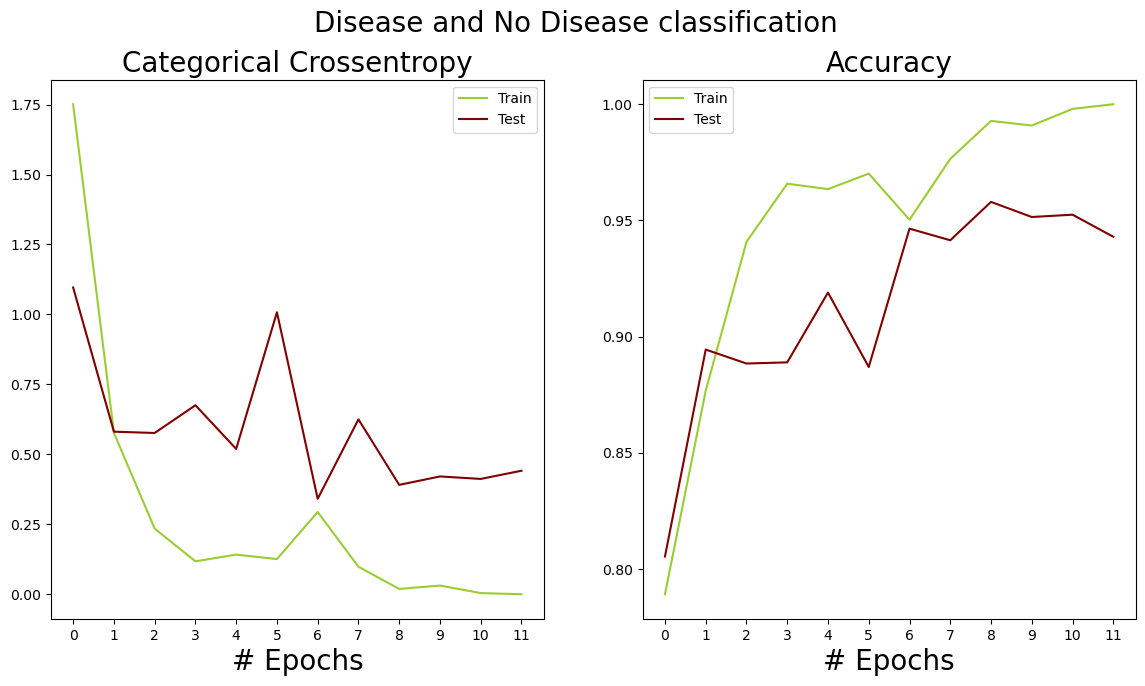

In [49]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h, 'Disease and No Disease classification')

Accuracy_score: 0.9464 



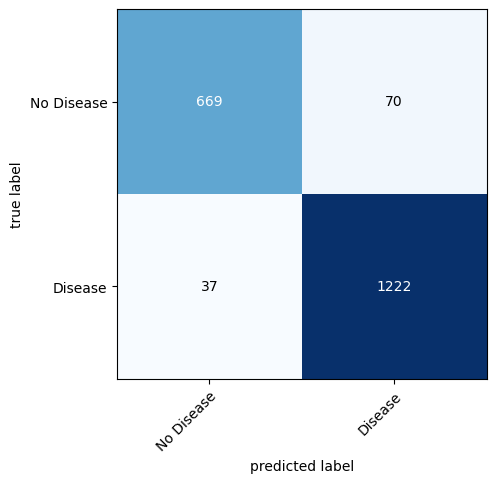

In [50]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['No Disease', 'Disease'], binary = True)

Accuracy_score: 0.7902 



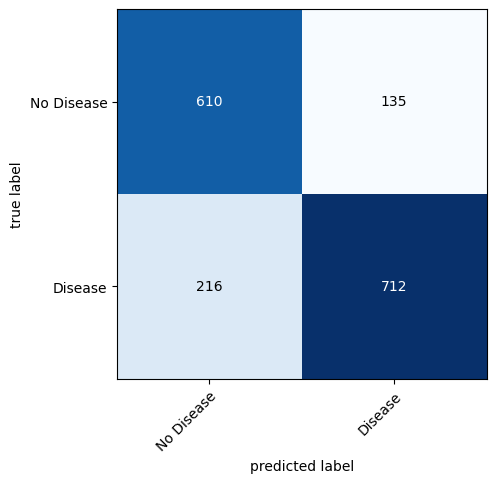

In [51]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['No Disease', 'Disease'], binary = True)

In [52]:
# model.save('../models/disease_no_disease.hdf5')  the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

This model is overfitting, it gives 79% accuracy on test set and 94 on validation set. I will try to combat overfitting by applying augmentation.

## Make Binary data Disease - No disease - with Augmentation
Combine datasets and make binary data - disease - 1, no disease - 0

In [34]:
# Augmentation transformations using Albumentations with best results for Disease or No Disease classification.
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.25),
    A.Rotate(limit=10, p=0.5)    
])

In [35]:
X_train_aug, X_val, y_train_aug, y_val = combine_images_from_two_path_binary(al_path_train, bt_path_train, augmentation = True)
X_train_aug.shape, y_train_aug.shape

((11986, 240, 240, 3), (11986,))

In [36]:
# X_test, y_test and ResNet50 stay the same
model_aug = Sequential()

model_aug.add(rn_model_bi)
model_aug.add(Flatten())

#Just use a single output layer
model_aug.add(Dense(1, activation='sigmoid'))

# Compile
model_aug.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h_aug = model_aug.fit(X_train_aug, y_train_aug, validation_data = (X_val, y_val), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
375/375 [==============================] - 459s 1s/step - loss: 1.4107 - accuracy: 0.7773 - val_loss: 1.0413 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 2/30
375/375 [==============================] - 463s 1s/step - loss: 0.7853 - accuracy: 0.8593 - val_loss: 1.4624 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 3/30
375/375 [==============================] - 462s 1s/step - loss: 0.5809 - accuracy: 0.8888 - val_loss: 0.7445 - val_accuracy: 0.9054 - lr: 0.0010
Epoch 4/30
375/375 [==============================] - 462s 1s/step - loss: 0.3709 - accuracy: 0.9203 - val_loss: 0.4514 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 5/30
375/375 [==============================] - 467s 1s/step - loss: 0.3439 - accuracy: 0.9316 - val_loss: 0.7539 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 6/30
375/375 [==============================] - 470s 1s/step - loss: 0.5478 - accuracy: 0.9131 - val_loss: 3.0738 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 7/30
375/375 [==============================] - 471s 1s/st

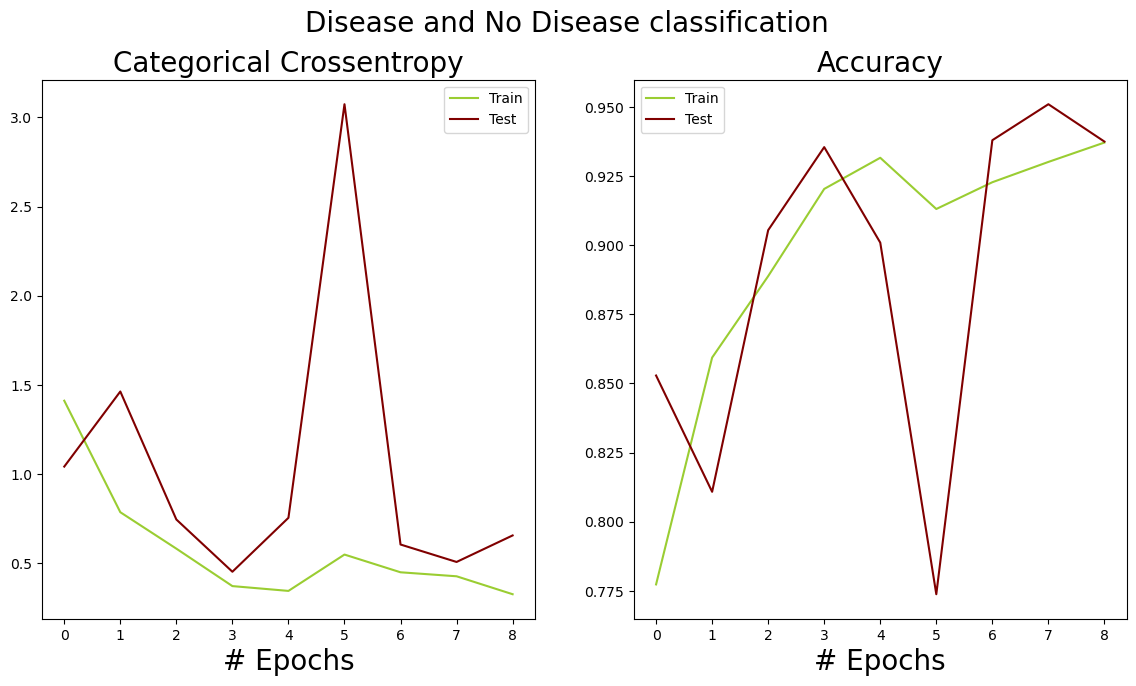

In [37]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_aug, 'Disease and No Disease classification')

Accuracy_score: 0.9354 



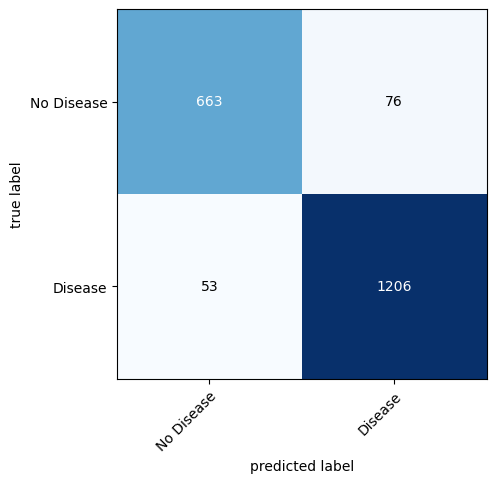

In [38]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_aug, X=X_val, y=y_val, class_names_list =  ['No Disease', 'Disease'], binary = True)

Accuracy_score: 0.7794 



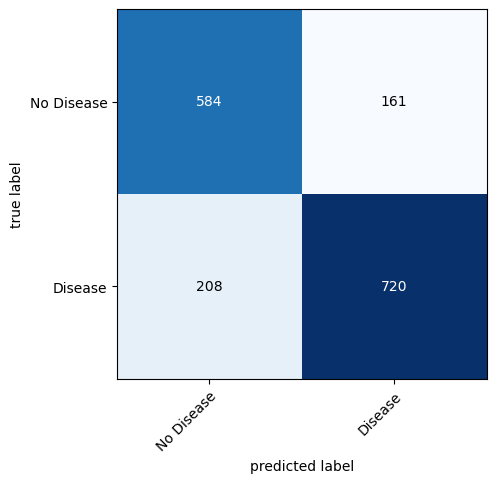

In [39]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_aug, X=X_test, y=y_test, class_names_list =  ['No Disease', 'Disease'], binary = True)

In [40]:
# model_aug.save('../models/disease_no_disease_aug.hdf5') the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

Augmentation did not improve the accuracy. Without Augmentation 79%, with the best augmentation from the previous notebook - 74% and best after tuning the probabilities 78%

## Make Binary data Alzheimer's - Brain tumor. 
Combine datasets, ignoring No disease images and make binary data - Alzheimer's  - 0, Brain tumor - 1

In [53]:
X_train_al_bt, X_val_al_bt, y_train_al_bt, y_val_al_bt = combine_images_from_two_path_binary(al_path_train, bt_path_train, function = al_bt_load_img_from_dir_binary)
X_train_al_bt.shape, y_train_al_bt.shape

((3777, 240, 240, 3), (3777,))

In [ ]:
X_test_al_bt, y_test_al_bt = combine_images_from_two_path_binary(al_path_test, bt_path_test, function = al_bt_load_img_from_dir_binary)

In [55]:
effnet_bi = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classifier_activation="sigmoid",
    include_preprocessing=True,
)

# Freeze last 5 layers
for layer in effnet_bi.layers[:-5]:
    layer.trainable = False

In [56]:
model_al_bt = Sequential()

model_al_bt.add(effnet_bi)
model_al_bt.add(GlobalAveragePooling2D())


#Just use a single output layer
model_al_bt.add(Dense(1, activation='sigmoid'))

# Compile
model_al_bt.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

h_al_bt = model_al_bt.fit(X_train_al_bt, y_train_al_bt, validation_data = (X_val_al_bt, y_val_al_bt), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
119/119 [==============================] - 243s 2s/step - loss: 0.1225 - accuracy: 0.9550 - val_loss: 0.0294 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 2/30
119/119 [==============================] - 251s 2s/step - loss: 0.0528 - accuracy: 0.9780 - val_loss: 0.0142 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 3/30
119/119 [==============================] - 234s 2s/step - loss: 0.0370 - accuracy: 0.9860 - val_loss: 0.0130 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 4/30
119/119 [==============================] - 225s 2s/step - loss: 0.0346 - accuracy: 0.9860 - val_loss: 0.0073 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 5/30
119/119 [==============================] - 231s 2s/step - loss: 0.0349 - accuracy: 0.9846 - val_loss: 0.0096 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 6/30
119/119 [==============================] - 225s 2s/step - loss: 0.0331 - accuracy: 0.9860 - val_loss: 0.0086 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 7/30
119/119 [==============================] - 223s 2s/st

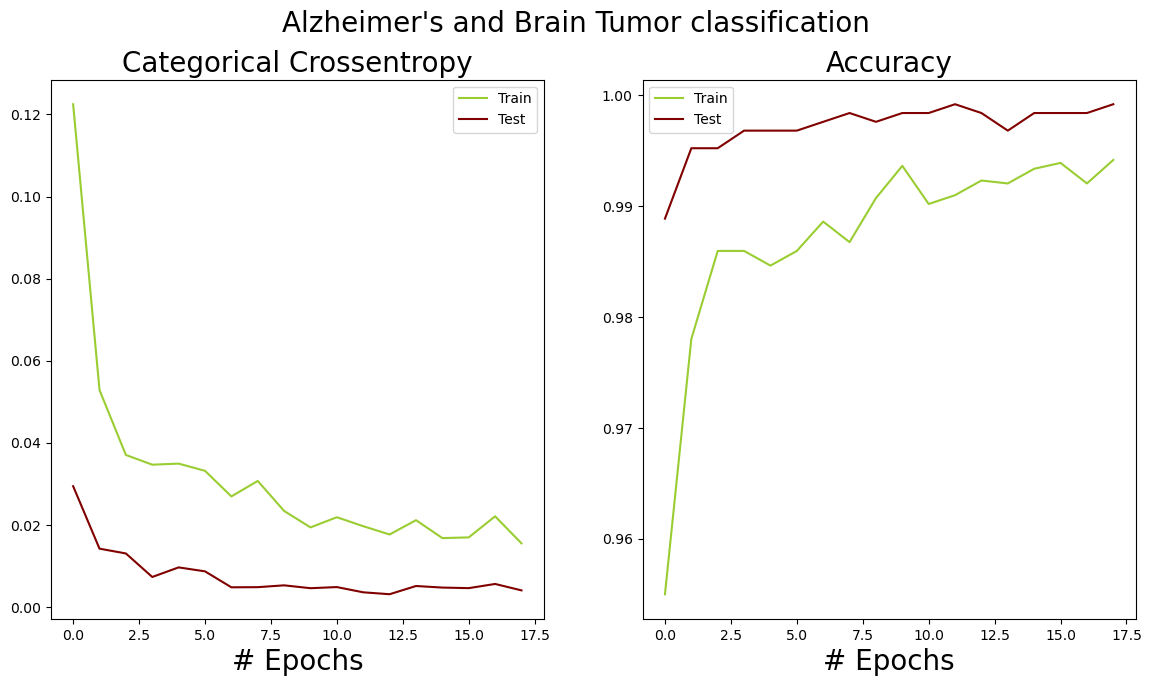

In [57]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al_bt, 'Alzheimer\'s and Brain Tumor classification')

Accuracy_score: 0.9984 



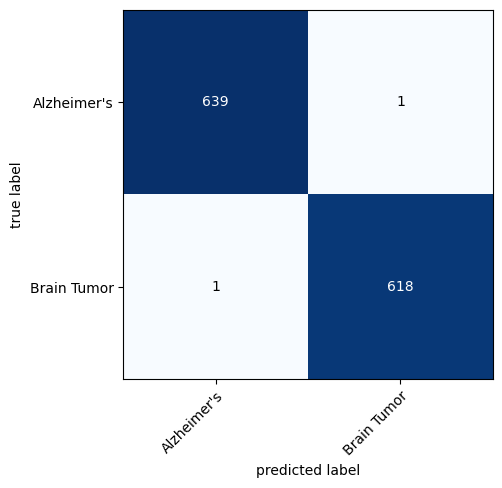

In [58]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_val_al_bt, y=y_val_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

Accuracy_score: 0.9989 



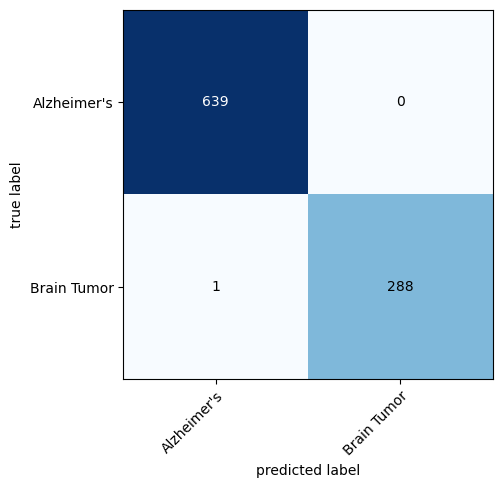

In [59]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_bt, X=X_test_al_bt, y=y_test_al_bt, class_names_list =  ['Alzheimer\'s', 'Brain Tumor'], binary = True)

In [72]:
# model_al_bt.save('../models/al_bt.hdf5')  the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

This model performs great. Only one MRI image was miscassified. I do not need to augment data for this model.

## Predict Sevetiry of Alzeimer's or Type of Brain Tumor

### Sevetiry of Alzeimer's - No Augmentation

In [61]:
X_train_al, X_val_al, y_train_al, y_val_al = load_img_from_dir_cat(al_path_train)
X_train_al.shape, y_train_al.shape

((1920, 240, 240, 3), (1920, 3))

In [9]:
X_test_al, y_test_al = load_img_from_dir_cat(al_path_test)

In [10]:
rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=3,
    classifier_activation="softmax"
)

In [11]:
for layer in rn_model.layers:
    layer.trainable = False

In [65]:
model_al = Sequential()

model_al.add(rn_model)
model_al.add(Flatten())

#Just use a single output layer
model_al.add(Dense(3, activation='softmax'))

# Compile
model_al.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_al = model_al.fit(X_train_al, y_train_al, validation_data = (X_val_al, y_val_al), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
60/60 [==============================] - 97s 2s/step - loss: 5.5810 - accuracy: 0.6969 - val_loss: 0.7421 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 95s 2s/step - loss: 0.2064 - accuracy: 0.9453 - val_loss: 0.4199 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 96s 2s/step - loss: 0.2485 - accuracy: 0.9354 - val_loss: 0.5069 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 94s 2s/step - loss: 0.1424 - accuracy: 0.9719 - val_loss: 0.4738 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 5/30
60/60 [==============================] - 95s 2s/step - loss: 0.1091 - accuracy: 0.9698 - val_loss: 0.5678 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 6/30
60/60 [==============================] - 94s 2s/step - loss: 0.2856 - accuracy: 0.9401 - val_loss: 0.3927 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 7/30
60/60 [==============================] - 97s 2s/step - loss: 0.0449 - a

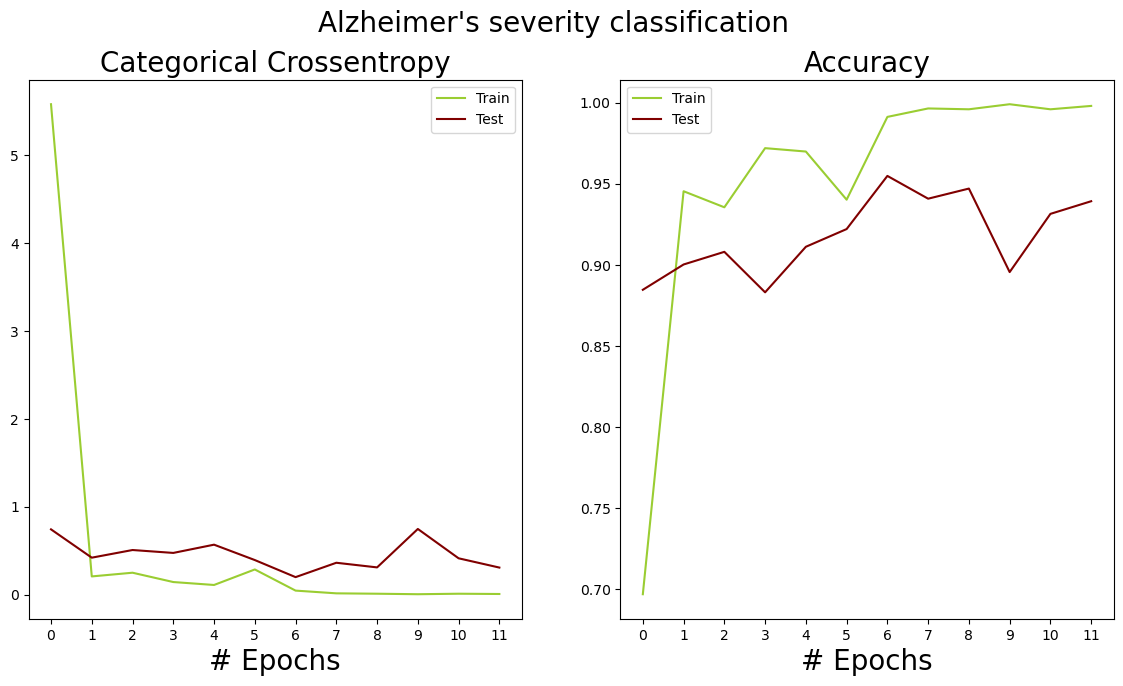

In [66]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al, 'Alzheimer\'s severity classification')

Accuracy_score: 0.9548 



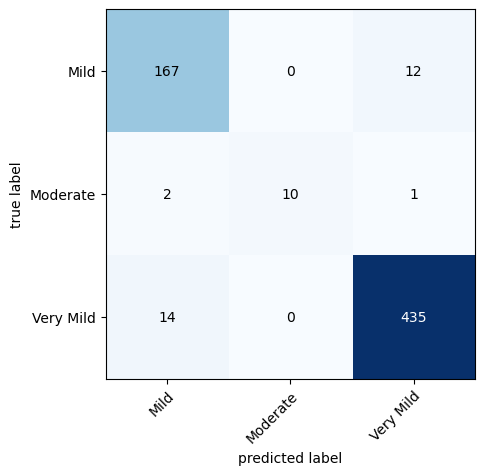

In [67]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_val_al, y=y_val_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

Accuracy_score: 0.7731 



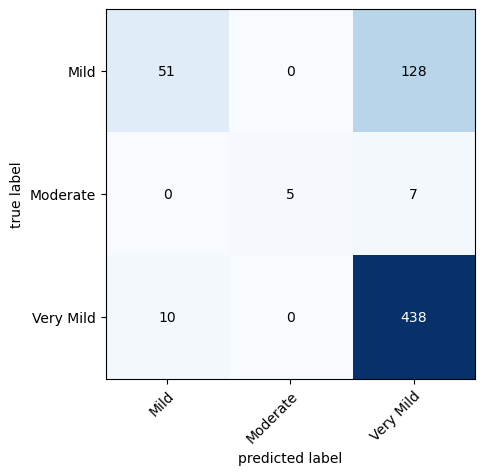

In [68]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al, X=X_test_al, y=y_test_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

In [69]:
# model_al.save('../models/model_al.hdf5') the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

The model is overfitting with 95% on validation set used during model training and 77% on test set. 

### Sevetiry of Alzeimer's - with Augmentation

In [106]:
# Augmentation transformations using Albumentations with best results for Alzheimer's disease classification (the same as for Disease or No Disease).
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.25),
    A.Rotate(limit=10, p=0.5)    
])

In [70]:
X_train_al_aug, X_val_al, y_train_al_aug, y_val_al = load_img_from_dir_cat(al_path_train, augmentation = True)
X_train_al_aug.shape, y_train_al_aug.shape

((3840, 240, 240, 3), (3840, 3))

In [71]:
# X_test, y_test and ResNet50 stay the same
model_al_aug = Sequential()

model_al_aug.add(rn_model)
model_al_aug.add(Flatten())

#Just use a single output layer
model_al_aug.add(Dense(3, activation='softmax'))

# Compile
model_al_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_al_aug = model_al_aug.fit(X_train_al_aug, y_train_al_aug, validation_data = (X_val_al, y_val_al), epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
120/120 [==============================] - 160s 1s/step - loss: 4.4093 - accuracy: 0.7042 - val_loss: 1.1109 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 162s 1s/step - loss: 1.2380 - accuracy: 0.8570 - val_loss: 5.5814 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 164s 1s/step - loss: 0.9118 - accuracy: 0.8966 - val_loss: 1.0677 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 4/30
120/120 [==============================] - 161s 1s/step - loss: 0.5821 - accuracy: 0.9234 - val_loss: 0.4304 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 5/30
120/120 [==============================] - 158s 1s/step - loss: 0.6455 - accuracy: 0.9174 - val_loss: 0.7071 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 6/30
120/120 [==============================] - 166s 1s/step - loss: 0.5773 - accuracy: 0.9294 - val_loss: 1.0545 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 7/30
120/120 [==============================] - 168s 1s/st

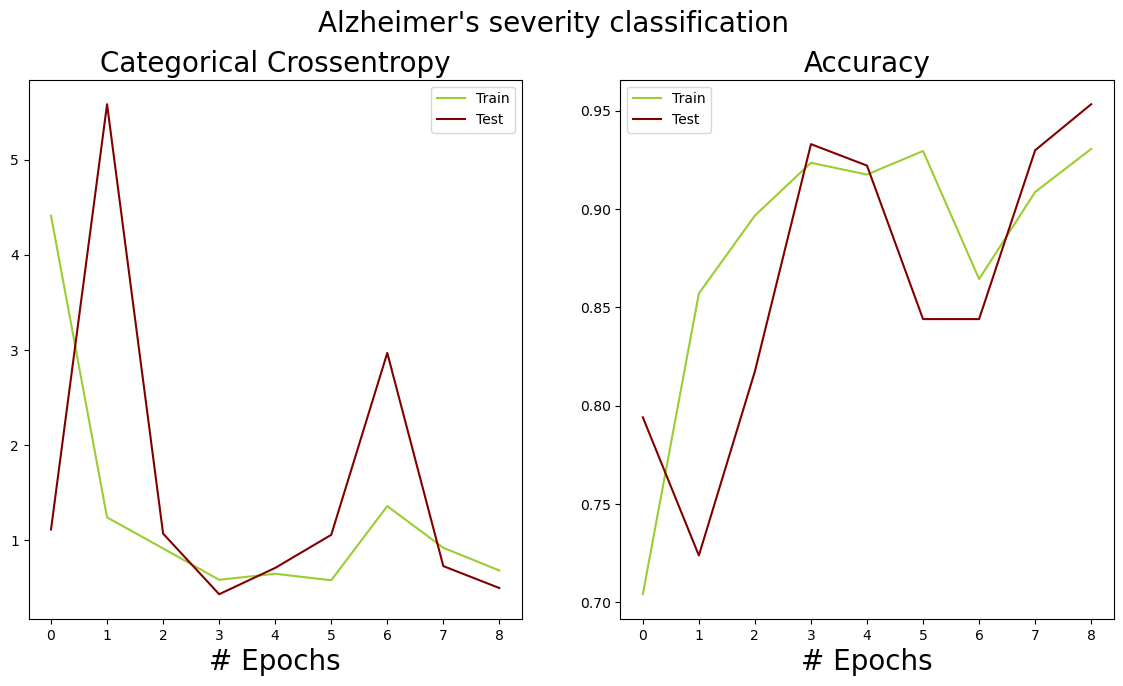

In [72]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_al_aug, 'Alzheimer\'s severity classification')

Accuracy_score: 0.9329 



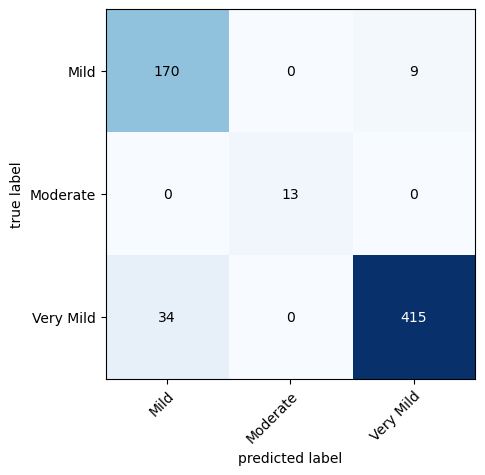

In [73]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_aug, X=X_val_al, y=y_val_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

Accuracy_score: 0.7872 



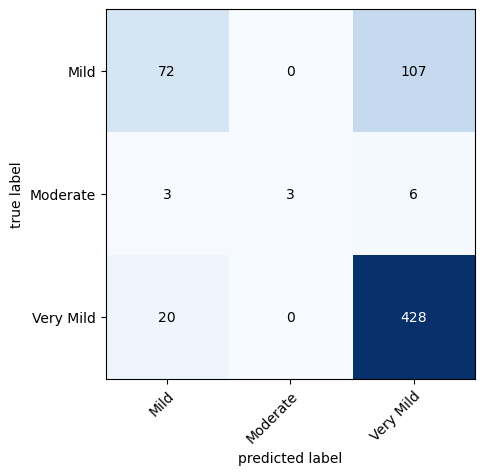

In [74]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_al_aug, X=X_test_al, y=y_test_al, class_names_list = ['Mild', 'Moderate', 'Very Mild'])

In [75]:
model_al_aug.save('../models/model_al_aug_2.hdf5') # the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

Augmentation improved the model accuracy from 77,3% to 78,2%

### Type of Brain Tumor - No Augmentation

In [70]:
X_train_bt, X_val_bt, y_train_bt, y_val_bt = load_img_from_dir_cat(bt_path_train)
X_train_bt.shape, y_train_bt.shape

((1856, 240, 240, 3), (1856, 3))

In [97]:
X_test_bt, y_test_bt = load_img_from_dir_cat(bt_path_test)

In [98]:
effnet = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=3,
    classifier_activation="softmax",
    include_preprocessing=True,
)
# Freeze last 5 layers
for layer in effnet.layers[:-5]:
    layer.trainable = False

In [73]:
model_bt = Sequential()

model_bt.add(effnet)
model_bt.add(GlobalAveragePooling2D())
model_bt.add(Dropout(.2))

#Just use a single output layer
model_bt.add(Dense(3, activation='softmax'))

# Compile
model_bt.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_bt = model_bt.fit(X_train_bt, y_train_bt, validation_data = (X_val_bt, y_val_bt), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
58/58 [==============================] - 119s 2s/step - loss: 0.5363 - accuracy: 0.7796 - val_loss: 0.3729 - val_accuracy: 0.8498 - lr: 0.0010
Epoch 2/30
58/58 [==============================] - 112s 2s/step - loss: 0.3549 - accuracy: 0.8578 - val_loss: 0.3309 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 3/30
58/58 [==============================] - 110s 2s/step - loss: 0.2980 - accuracy: 0.8885 - val_loss: 0.2769 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 4/30
58/58 [==============================] - 122s 2s/step - loss: 0.2509 - accuracy: 0.9106 - val_loss: 0.2489 - val_accuracy: 0.9095 - lr: 0.0010
Epoch 5/30
58/58 [==============================] - 108s 2s/step - loss: 0.2064 - accuracy: 0.9283 - val_loss: 0.2019 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 6/30
58/58 [==============================] - 104s 2s/step - loss: 0.1841 - accuracy: 0.9359 - val_loss: 0.1981 - val_accuracy: 0.9338 - lr: 0.0010
Epoch 7/30
58/58 [==============================] - 171s 3s/step - loss: 0.1

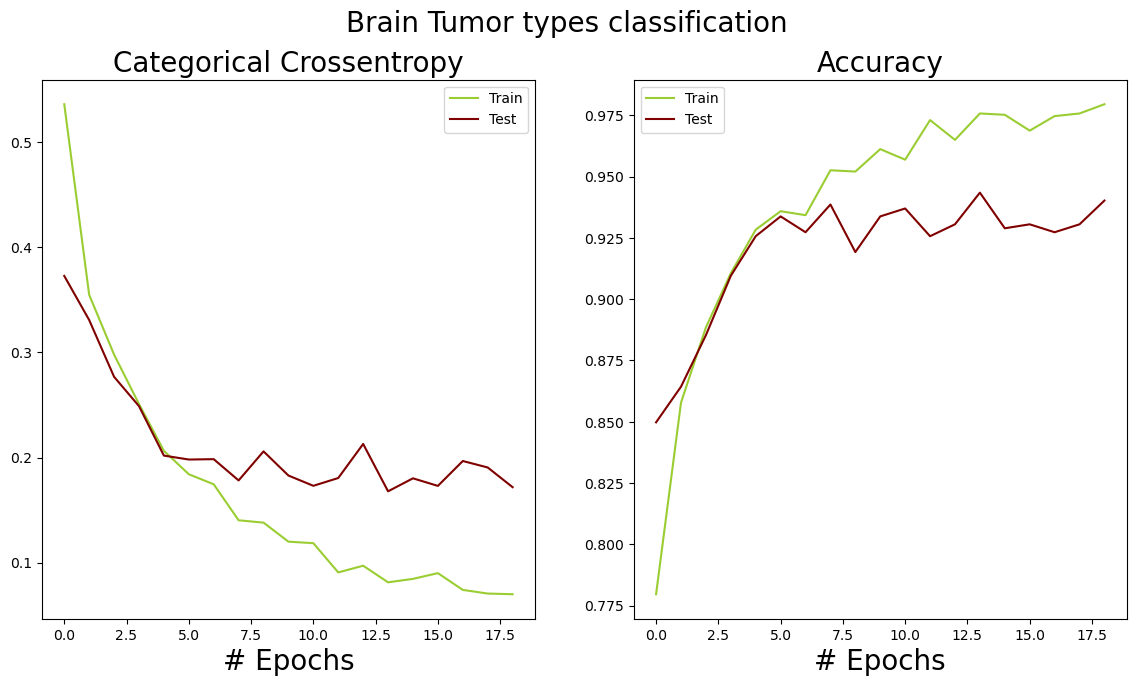

In [74]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_bt, 'Brain Tumor types classification')

Accuracy_score: 0.9435 



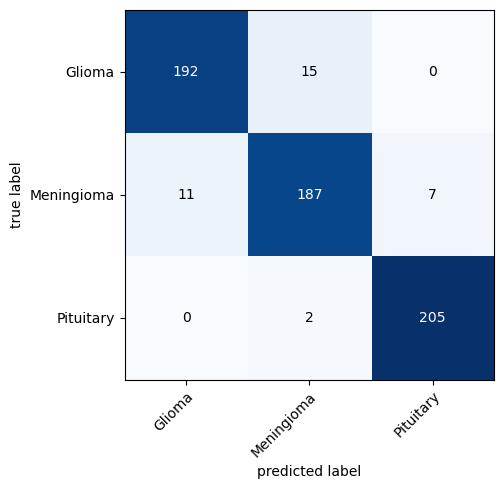

In [75]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_val_bt, y=y_val_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

Accuracy_score: 0.7093 



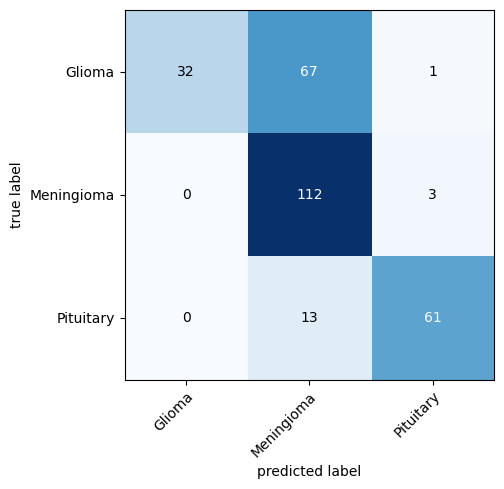

In [76]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt, X=X_test_bt, y=y_test_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

In [78]:
# model_bt.save('../models/model_bt.hdf5') the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

The model struggles to identify Glioma. It is overfitting with 94% on the Validation set and 70% accuracy on the test set.

### Type of Brain Tumor - With Augmentation

In [ ]:
# The best augmentation from the previous notebook.
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.5),
    A.Rotate(limit=10, p=0.5)    
])

In [56]:
X_train_bt_aug, X_val_bt, y_train_bt_aug, y_val_bt = load_img_from_dir_cat(bt_path_train, augmentation = True)
X_train_bt_aug.shape, y_train_bt_aug.shape

((3712, 240, 240, 3), (3712, 3))

In [57]:
# X_test_bt, y_test_bt and EfficientNetV2S stay the same

model_bt_aug = Sequential()

model_bt_aug.add(effnet)
model_bt_aug.add(GlobalAveragePooling2D())
model_bt_aug.add(Dropout(.2))

#Just use a single output layer
model_bt_aug.add(Dense(3, activation='softmax'))

# Compile
model_bt_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_bt_aug = model_bt_aug.fit(X_train_bt_aug, y_train_bt_aug, validation_data = (X_val_bt, y_val_bt), epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
116/116 [==============================] - 189s 2s/step - loss: 0.6219 - accuracy: 0.7117 - val_loss: 0.3817 - val_accuracy: 0.8465 - lr: 0.0010
Epoch 2/30
116/116 [==============================] - 182s 2s/step - loss: 0.4854 - accuracy: 0.7783 - val_loss: 0.2868 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 3/30
116/116 [==============================] - 181s 2s/step - loss: 0.4217 - accuracy: 0.8112 - val_loss: 0.2548 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 4/30
116/116 [==============================] - 181s 2s/step - loss: 0.4056 - accuracy: 0.8155 - val_loss: 0.2745 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 5/30
116/116 [==============================] - 182s 2s/step - loss: 0.3820 - accuracy: 0.8225 - val_loss: 0.2285 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 6/30
116/116 [==============================] - 179s 2s/step - loss: 0.3560 - accuracy: 0.8284 - val_loss: 0.2223 - val_accuracy: 0.9192 - lr: 0.0010
Epoch 7/30
116/116 [==============================] - 180s 2s/st

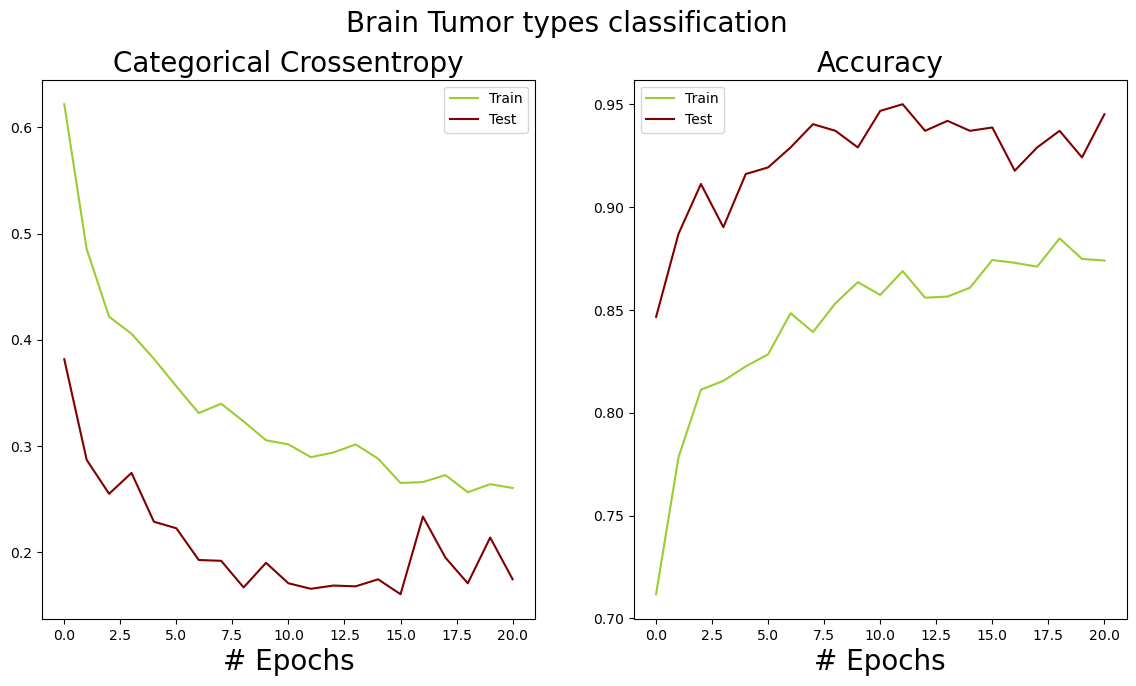

In [58]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_bt_aug, 'Brain Tumor types classification')

Accuracy_score: 0.9386 



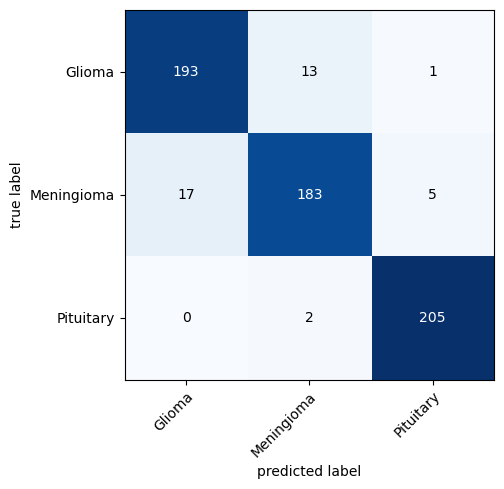

In [59]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt_aug, X=X_val_bt, y=y_val_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

Accuracy_score: 0.7578 



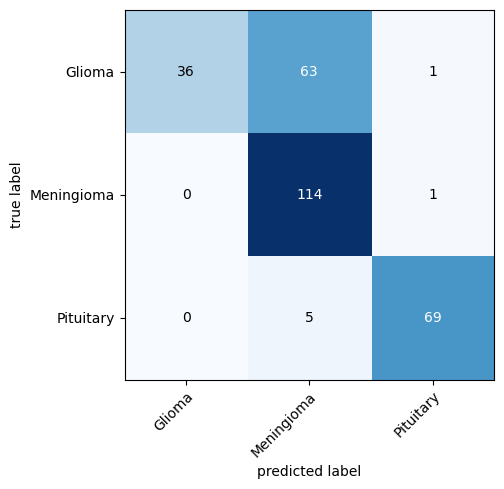

In [60]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model_bt_aug, X=X_test_bt, y=y_test_bt, class_names_list = ['Glioma', 'Meningioma', 'Pituitary'])

In [61]:
# model_bt_aug.save('../models/model_bt_aug.hdf5') the models are too big for git (over 50 MB limit) you can see them in https://drive.google.com/drive/folders/1c6tiwYgU2JKSHqd8JnuYHc5rYQC3wRYI?usp=share_link

Augmentation improved the model accuracy in classifing Brain Tumor type from 71% to 76%.

## Combine all to classify a single input image

Classifying Disease or No Disease worked better without Augmentation, Alzheimer's or Brain tumor was great without augmentation and Alzheimer's severity and Brain tumor type worked better with augmentation. I will combine my best models to create function for classifing single imput image.

In [117]:
def preprosses_image(image_path):
    '''
    Preprosses a single image for TensorFlow predictions.
    Input: image_path - string, path to the single image
    Return: image converted to array
    '''
    test_img = load_img(image_path, target_size=(image_size, image_size), color_mode='grayscale') # Read grayscale image and set size 
    test_img = expand_dims(test_img, -1) # Change from (image_size, image_size) to (image_size, image_size, 1)
    test_img = grayscale_to_rgb(test_img) # Change from (image_size, image_size, 1) to (image_size, image_size, 3) adding the same data to all channels
    test_img = img_to_array(test_img) 
    test_img = expand_dims(test_img, 0) # Change to (1, image_size, image_size, 3) for TensorFlow model 
    return test_img

In [132]:
def predict_image(image_path):
    '''
    Predicting disease on a single image using combined models Disease or No Disease, Alsheimer\'s or Brain tumor, Severity of Alzheimer's or Type of Brain tumor
    Input: image_path - string, path to the single image
    Return: classification - string, classification from combined models
    '''
    test_img = preprosses_image(image_path)
    pred_dis = (model.predict(test_img, verbose = False) > 0.5).astype("int32")
    if pred_dis[0][0] == 0:
        return 'No disease found in MRI'
    else:
        predict_al_bt = (model_al_bt.predict(test_img, verbose = False) > 0.5).astype("int32")
        if predict_al_bt[0][0] == 0:
            predict_al = model_al_aug.predict(test_img, verbose = False).argmax(axis=1)[0]
            al_list = ['Mild', 'Moderate', 'Very Mild']
            return f'{al_list[predict_al]} Alzheimer\'s'
        else:
            predict_bt = model_bt_aug.predict(test_img, verbose = False).argmax(axis=1)[0]
            bt_list = ['Glioma', 'Meningioma', 'Pituitary']
            return f'{bt_list[predict_bt]} Brain Tumor'  

In [137]:
predict_image('../data/alzheimer/test/MildDemented/27 (25).jpg')

"Mild Alzheimer's"

In [134]:
predict_image('../data/brain_tumor/test/meningioma_tumor/image(2).jpg')

'Meningioma Brain Tumor'

In [135]:
predict_image('../data/brain_tumor/test/no_tumor/image(10).jpg')

'No disease found in MRI'

---